# Overfitting and Regularization

## Imports

In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [182]:
set_config(display='diagram')

## Settings

In [183]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [184]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Split

In [185]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [186]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])


## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [187]:
def plot_graph(x, metric_train, xlabel, ylabel, title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.show()

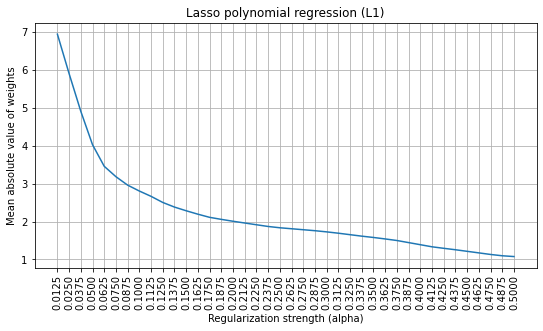

In [188]:
avg_coef = []
for alpha in ALPHAS[1:]:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    avg_coef.append(   
        np.mean([            
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_graph(ALPHAS[1:], avg_coef,
                   xlabel='Regularization strength (alpha)', ylabel='Mean absolute value of weights',
                   title='Lasso polynomial regression (L1)')

#### L2

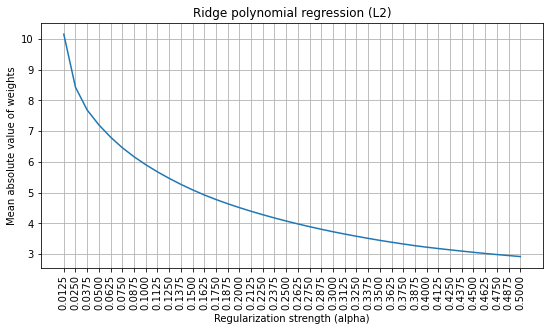

In [189]:
avg_coef = []
for alpha in ALPHAS[1:]:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    avg_coef.append(   
        np.mean([            
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_graph(ALPHAS[1:], avg_coef,
                   xlabel='Regularization strength (alpha)', ylabel='Mean absolute value of weights',
                   title='Ridge polynomial regression (L2)')

#### Summary

As we can see both L1 and L2 regularizations are trying to reduce weights as much as possible. L1 does this better and faster. In my opinion the reason is that L1 nullifies some weight

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [190]:
def plot_coef_graph(x, metric_train, xlabel, ylabel, title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    for i in range(metric_train.shape[1]):
        plt.plot(x, coef_matrix[:,i], label = 'w'+str(i))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='center right')      
    plt.xticks(x, rotation='vertical')
    plt.show()

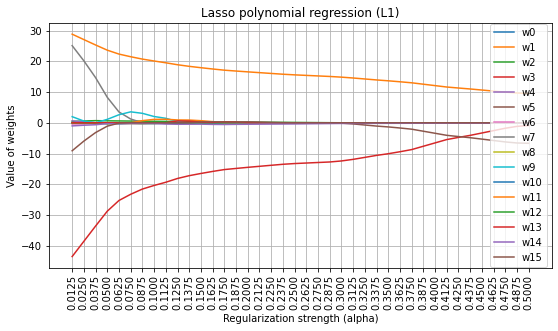

In [191]:
coef_matrix = np.zeros((1, 15 + 1))
for alpha in ALPHAS[1:]:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    weights = [model['reg'].coef_ for model in results['estimator']]
    weights = np.array(sum(np.array(weights))) / 5
    coef_matrix = np.r_[coef_matrix,np.asmatrix(weights)]
coef_matrix = np.delete(coef_matrix, 0, 0)
    

plot_coef_graph(ALPHAS[1:],coef_matrix,
                   xlabel='Regularization strength (alpha)', ylabel='Value of weights',
                   title='Lasso polynomial regression (L1)')

#### L2

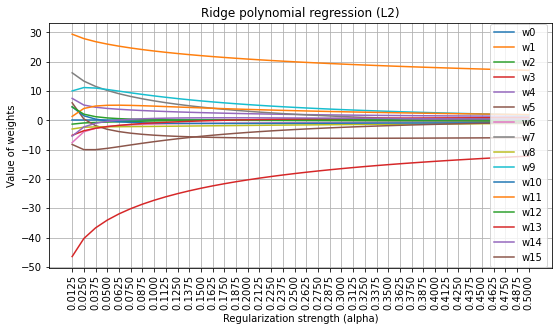

In [192]:
coef_matrix = np.zeros((1, 15 + 1))
for alpha in ALPHAS[1:]:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    weights = [model['reg'].coef_ for model in results['estimator']]
    weights = np.array(sum(np.array(weights))) / 5
    coef_matrix = np.r_[coef_matrix,np.asmatrix(weights)]
coef_matrix = np.delete(coef_matrix, 0, 0)
    

plot_coef_graph(ALPHAS[1:],coef_matrix,
                   xlabel='Regularization strength (alpha)', ylabel='Value of weights',
                   title='Ridge polynomial regression (L2)')

#### Summary

Here you can see how both L1 and L2 regularizations behave with different regularization strength. L1 set almost all weights to zero, in some period of time only two weights were not zero. On the contrary L2 only inlcline weights to zero. If you compare two plots you can notice that both regularizations left the same weights w15, w13, w1. In my opinion the reason is that the combination of these weight represents the target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ better than the rest.

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

For understanding what features scaling is let's consider an example. We have a set of data about flats. The data contains information about flat age, size and price. See the table.

| Age(y) | Size(m2) | Price($) |
| --- | --- | --- |
| 1 | 100 | 45 000 |
| 12 | 150 | 60 000 |
| 5 | 40 | 30 000 |

We want to predict the price according age and size. Since computer is just a machine, it doesn't understand the importance of features(age and size). It can only figure out what is more, as size > age it has more importance on price. So when you train a model this feature will be a decisive. Of course it will affect your model. In result your model will not work quite correctly.
Feature scaling is used to avoid a situation like this. It helps to represent all the features in the same range. As the features are equally they have the same importance. See the table.

| Age(y) | Size(m2) | Price($) |
| --- | --- | --- |
| 0 | 0.54 | 0.5  |
| 1 | 1 | 1  |
| 0.36 | 0 | 1  |

Let's talk about linear regression. We can see that unscalled features influence on wight in the linear regression. As you remember in training of simple linear regression weights don't take part in. 



It means we don't have to use scaling with the simple linear regression. But there is another situation with the linear regression + Regularization. As you remember L1 and L2 regularization have the next formulas:

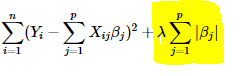
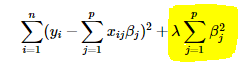

As you can see the weights have a big influence on the result. So without scaling your model will mispredict the results.

There are a lot of other reasons why you have to use scaling, f.e. some algorithms can work faster with scaled data. But in my opinion we have considered the most important one.